# ARIMA

[Autoregressive Integrated Moving Average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) `ARIMA` is a way to model time series data based its own past values. ARIMA is actually the combination of three things:

- `AR`: autoregressive model (using lagged time series values),
- `I`: integrated processing (differencing time series values), and
- `MA`: moving average model (using lagged forecast error values).

Thus, 

- ARIMA = AR + I + MA.

It should be noted that the order of operation actually starts with integrated processing followed by autoregressive and moving average modeling. However, ARIMA sounds better than IARMA. 

There are 3 hyperparameters `p`, `q` and `d` to consider in an ARIMA model.

- p: order of AR term; number of lags to be used as predictors; used to remove autocorrelation from stationarized time series
- q: order of MA term; number of lagged forecast errors that should be used; used to remove autocorrelation from stationarized time series
- d: minimum number of differencing required to make the time series stationary (a time series is stationary when the distribution of values is time-invariant or does not depend on time)

ARIMA models are often written as ARIMA(p, d, q), which is essentially

- ARIMA = AR(p) + I(d) + MA(q)

Certain combinations of p, q, d values create an ARIMA model that has special properties associated with characterizing names.

- ARIMA(0, 0, 0): white noise
- ARIMA(0, 1, 0): random walk
- ARIMA(0, 1, 1): basic exponential smoothing
- ARIMA(0, 1, 2): Damped Holt's model
- ARIMA(0, 2, 1): linear exponential smoothing
- ARIMA(0, 2, 2): double exponential smoothing
- ARIMA(1, 0, 0): first-order autoregressive
- ARIMA(1, 1, 0): differenced first-order autoregressive
- ARIMA(1, 1, 2): damped-trend linear exponential smoothing

The `AR` model is given as follows.

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + e_1$

The `MA` model is given as follows.

$Y_t = \alpha + e_t + \phi_1 e_{t-1} + \phi_2 e_{t-2} + \ldots + \phi_q e_{t-q}$

The errors $e_t, e_{t-1}, \ldots, e_{t-q}$ are the errors from the following equations.

- $Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_0 + e_t$
- $Y_{t-1} = \beta_1 Y_{t-2} + \beta_2 Y_{t-3} + \ldots + \beta_0 Y_0 + e_{t-1}$
- $Y_{t-q} = \beta_1 Y_{t-q-1} + \beta_2 Y_{t-q-2} + \ldots + \beta_0 Y_0 + e_{t-q}$

The fully expanded ARIMA model is written as follows.

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + e_t + \phi_1 e_{t-1} + \phi_2 e_{t-2} + \ldots + \phi_q e_{t-q}$

ARIMA models may consider a single time series variable (univariate) or multiple (multivariate). Also, the time series data should be collected with a constant time interval.  Seasonality (predictable, repeating patterns) may also be modeled with ARIMA, and such modeling is called `SARIMA`.

## Synthesize data

Let's synthesize a time series data based on the `sin()` function with a little noise sampled from $\mathcal{N}(0, 0.1)$.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(37)

N = 100
s = pd.Series(np.sin(np.arange(N)) + np.random.normal(0, 0.1, N))

## Determine p, q, d

The values p, q and d can be determined quantitatively or qualitatively (visually).

- p may be determined from a partial autocorrelation plot
- q may be determined from an autocorrelation plot
- q may be determined using the [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs

def plot_data(s):
    adf_stat, p_val, *_ = adfuller(s)
    n_diffs = ndiffs(s)
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 5.5))
    ax = np.ravel(ax)

    _ = s.plot(ax=ax[0])
    _ = s.plot(kind='kde', ax=ax[1])
    _ = plot_acf(
        s, 
        title=f'Autocorrelation, MA(q)', 
        ax=ax[2]
    )
    _ = plot_pacf(
        s, 
        method='ywm', 
        title='Partial Autocorrelation, AR(p)', 
        ax=ax[3]
    )
    
    ax[0].set_title(('Time Series'
                     '\n'
                     f'ADF={adf_stat:.2f}, '
                     f'p-val={p_val:.2f}, d={n_diffs}'))
    ax[1].set_title('Distribution')
    
    plt.tight_layout()

These are plots of the time-series (not differenced) and its distribution, autocorrelation and partial autocorrelation.

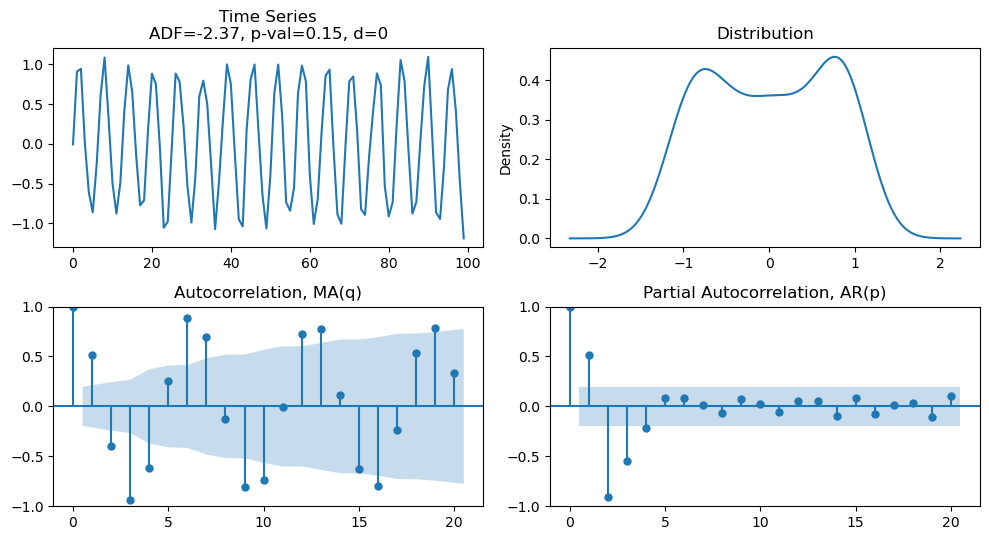

In [3]:
plot_data(s)

These are plots of the time-series (differenced once) and its distribution, autocorrelation and partial autocorrelation.

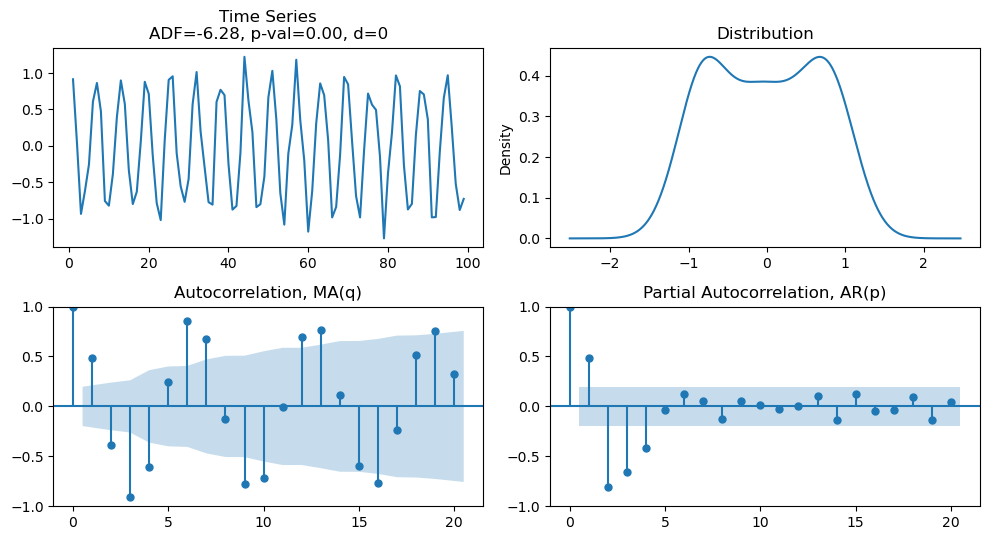

In [4]:
plot_data(s.diff().dropna())

These are plots of the time-series (differenced twice) and its distribution, autocorrelation and partial autocorrelation.

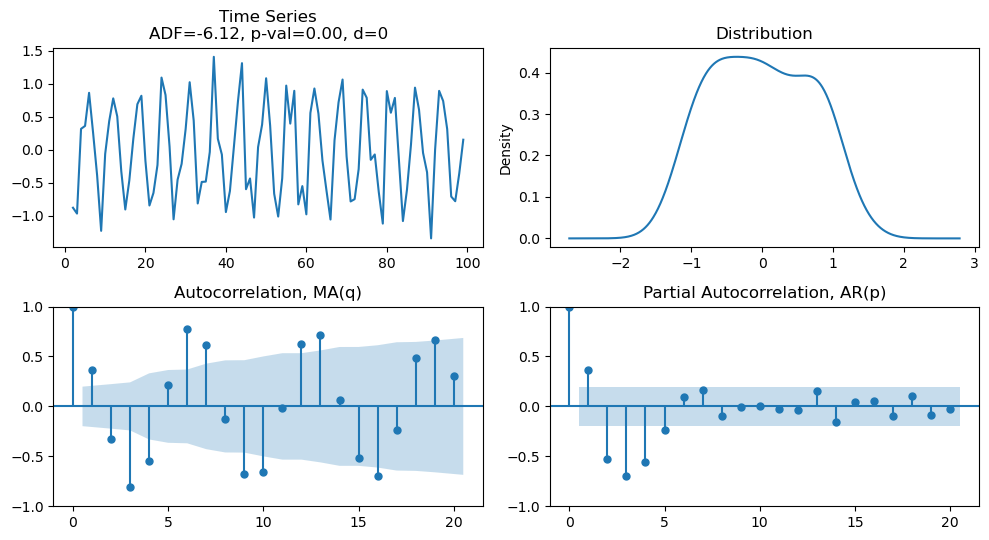

In [5]:
plot_data(s.diff().diff().dropna())

## ARIMA modeling

You will have to play with the hyperparameter values. The implementation from `statsmodel` is subject to numerical instability. In general, you want the `AIC` to be as high as possible and the coefficients to be significant.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

p = 1 # AR
q = 1 # MA
d = 0 

model = ARIMA(s, order=(p, d, q))
fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -61.055
Date:                Thu, 27 Oct 2022   AIC                            130.111
Time:                        04:04:10   BIC                            140.532
Sample:                             0   HQIC                           134.328
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0089      0.130     -0.069      0.945      -0.264       0.246
ar.L1          0.3938      0.126      3.116      0.002       0.146       0.642
ma.L1          0.7678      0.079      9.685      0.000       0.612       0.923
sigma2         0.1954      0.041      4.745      0.000       0.115       0.276
===================================================================================
Ljung-Box (L1) (Q):                   4.71   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.03   Prob(JB):                         0.12
Heteroskedasticity (H):               1.09   Skew:                            -0.03
Prob(H) (two-sided):                  0.81   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here is the residual plot.

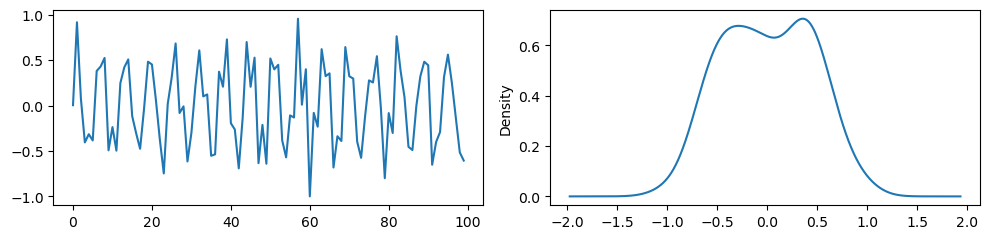

In [7]:
r = pd.Series(fit.resid)

fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

r.plot(ax=ax[0])
r.plot(kind='kde', ax=ax[1])

plt.tight_layout()

Here is a plot of the true versus predicted values.

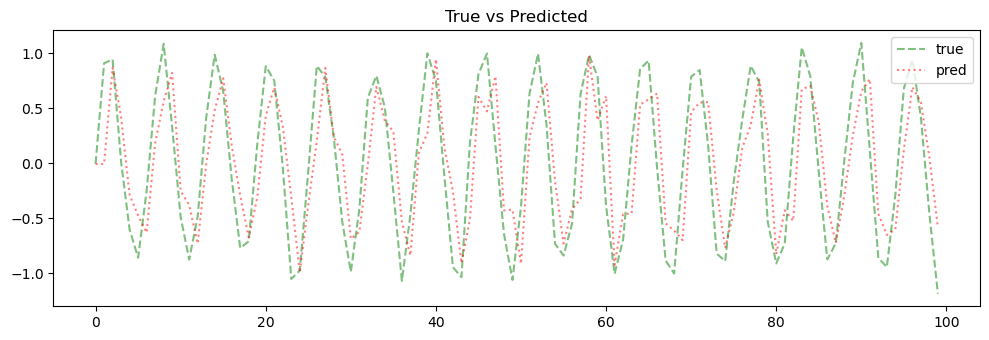

In [8]:
fig, ax = plt.subplots(figsize=(10, 3.5))

_ = s.plot(
    color='green', 
    alpha=0.5, 
    linestyle='dashed', 
    label='true',
    ax=ax
)

_ = pd.Series(fit.predict(dynamic=False)) \
    .plot(
        color='red', 
        alpha=0.5, 
        linestyle='dotted', 
        label='pred',
        ax=ax
    )

_ = ax.legend()
_ = ax.set_title('True vs Predicted')

plt.tight_layout()

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def lag_data(s, n):
    df = pd.DataFrame({f't_{shift}' if shift > 0 else 'y': s.shift(shift) 
                       for shift in range(p + 1)})
    return df
    
def do_ar(s, p, tr_size=0.8):
    df = pd.DataFrame({f't_{shift}': s.shift(shift) for shift in range(p + 1)})
    N = int(np.ceil(tr_size * df.shape[0]))
    
    df_tr = df[:N].dropna()
    df_te = df[N:]
    
    X_tr, y_tr = df_tr.iloc[:,1:], df_tr.iloc[:,0]
    X_te, y_te = df_te.iloc[:,1:], df_te.iloc[:,0]
    
    m = LinearRegression()
    m.fit(X_tr, y_tr)
    
    y_pred_tr = m.predict(X_tr)
    y_pred_te = m.predict(X_te)
    
    df_tr = df_tr.assign(y_pred=y_pred_tr)
    df_te = df_te.assign(y_pred=y_pred_te)
    
    mae_te = mean_absolute_error(y_te, y_pred_te)
    mse_te = mean_squared_error(y_te, y_pred_te)
    
    return {
        'p': p,
        'df_tr': df_tr,
        'df_te': df_te,
        'model': m,
        'mae': mae_te,
        'mse': mse_te
    }

ar_df = pd.DataFrame([do_ar(s, p) for p in range(1, 10)]) \
    .sort_values(['mae']) \
    .reset_index(drop=True)

ar_df

,p,df_tr,df_te,model,mae,mse
0,4,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.068340,0.010218
1,5,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.073858,0.010588
2,9,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.088295,0.012173
3,6,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.091011,0.013216
4,7,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.091306,0.011663
5,3,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.096598,0.015508
6,8,t_0 t_1 t_2 t_3 ...,t_0 t_1 t_2 t_3 ...,LinearRegression(),0.097978,0.013591
7,2,t_0 t_1 t_2 y_pred 2 ...,t_0 t_1 t_2 y_pred 80 ...,LinearRegression(),0.135609,0.031888
8,1,t_0 t_1 y_pred 1 0.908902 ...,t_0 t_1 y_pred 80 -0.912221 ...,LinearRegression(),0.566168,0.386658


In [19]:
df = pd.DataFrame({
    't1': s.shift(-1),
    't': s
}).dropna()

X = df[df.columns.drop(['t'])]
y = df['t']

In [22]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X, y)

y_pred = m.predict(X)

<AxesSubplot:>

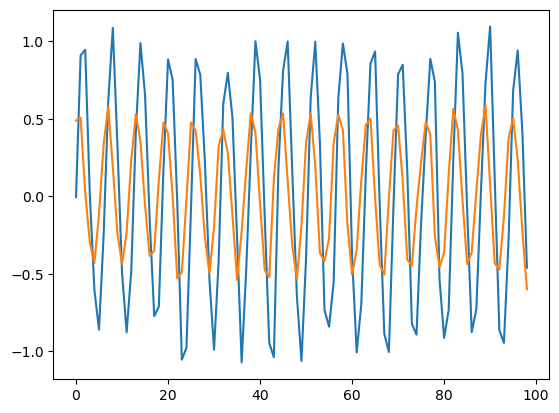

In [25]:
y.plot()
pd.Series(y_pred).plot()

In [28]:
df = df.assign(e1=y - y_pred)

In [32]:
X = df[df.columns.drop(['t'])]
y = df['t']

m = LinearRegression()
m.fit(X, y)

y_pred = m.predict(X)

<AxesSubplot:>

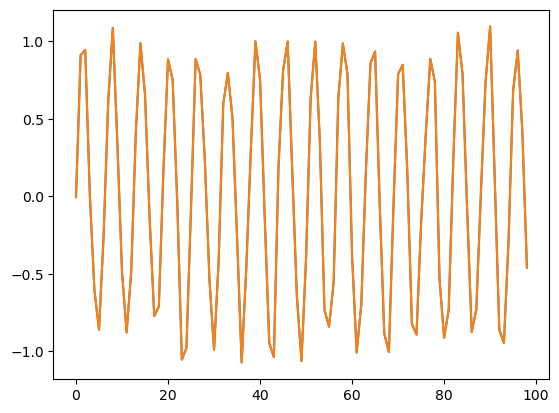

In [33]:
y.plot()
pd.Series(y_pred).plot()

## Links

- [ARIMA Model - Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
- [What Is ARIMA Modeling?](https://www.mastersindatascience.org/learning/statistics-data-science/what-is-arima-modeling/#:~:text=ARIMA%20is%20an%20acronym%20for,future%20data%20in%20a%20series.)
- [Shampoo time series data](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
- [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm)
- [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
- [Time Series Analysis Handbook](https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html)
- [Applied Time Series Analysis](https://online.stat.psu.edu/stat510/)
- [ARIMA Model from Scratch in Python](https://medium.com/analytics-vidhya/arima-model-from-scratch-in-python-489e961603ce)